In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix, accuracy_score, recall_score, \
    ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


## Prediction with random Forest
The Data needs to be updated, so for testing, I used a subset of the data with no missing values

In [7]:
turtles = pd.read_csv('data/turtles_cleaned.csv')
turtles.dropna(inplace=True)

In [8]:
X = turtles.drop(columns=['CaptureSite', 'CaptureSiteCategory'])
y = turtles['CaptureSite']
y_alt = turtles['CaptureSiteCategory']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(X, y_alt, test_size=0.30, random_state=42, stratify=y)

### Random Forest Pipline

### Random Forest classification pipeline with hyperparameter optimization

This section builds a preprocessing + RandomForest pipeline, performs hyperparameter optimization with cross-validated grid search on `X_train, y_train`, and evaluates the best model on the test set.

In [21]:
categorical_features = ['ForagingGround', 'Species', 'CalendarWeek']
numeric_features = ['CCL_cm', 'CCW_cm', 'Weight_Kg']

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ]
)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', rf_clf)
])

param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 20, 30],
    'rf__min_samples_split': [2, 3, 5],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__criterion': ['gini'],              # 'entropy'
    'rf__max_features': ['sqrt']            # 'log2'
}

rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


rf_grid_search.fit(X_train, y_train)

rf_best_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
rf_best_score = rf_grid_search.best_score_

rf_grid_search.fit(X_train, y_train_alt)

rf_best_model_alt = rf_grid_search.best_estimator_
rf_best_params_alt = rf_grid_search.best_params_
rf_best_score_alt = rf_grid_search.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/filipo/Documents/NeueFische/Turtles-ML-project/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 5 folds for each of 108 candidates, totalling 540 fits


### Evaluation of the optimized Random Forest on the test set

In [22]:
y_pred = rf_best_model.predict(X_test)

rf_test_accuracy = accuracy_score(y_test, y_pred)
rf_test_f1_macro = f1_score(y_test, y_pred, average='macro')
rf_test_recall_macro = recall_score(y_test, y_pred, average='macro')
rf_cm = confusion_matrix(y_test, y_pred)

rf_test_accuracy, rf_test_f1_macro, rf_test_recall_macro

(0.3739130434782609, 0.11185071064356261, 0.12433218899133915)

In [23]:
y_pred_alt = rf_best_model_alt.predict(X_test)

rf_test_accuracy_alt = accuracy_score(y_test_alt, y_pred_alt)
rf_test_f1_macro_alt = f1_score(y_test_alt, y_pred_alt, average='macro')
rf_test_recall_macro_alt = recall_score(y_test_alt, y_pred_alt, average='macro')
rf_cm_alt = confusion_matrix(y_test_alt, y_pred_alt)

rf_test_accuracy_alt, rf_test_f1_macro_alt, rf_test_recall_macro_alt

(0.6656126482213439, 0.4136545995397915, 0.4301866256028741)

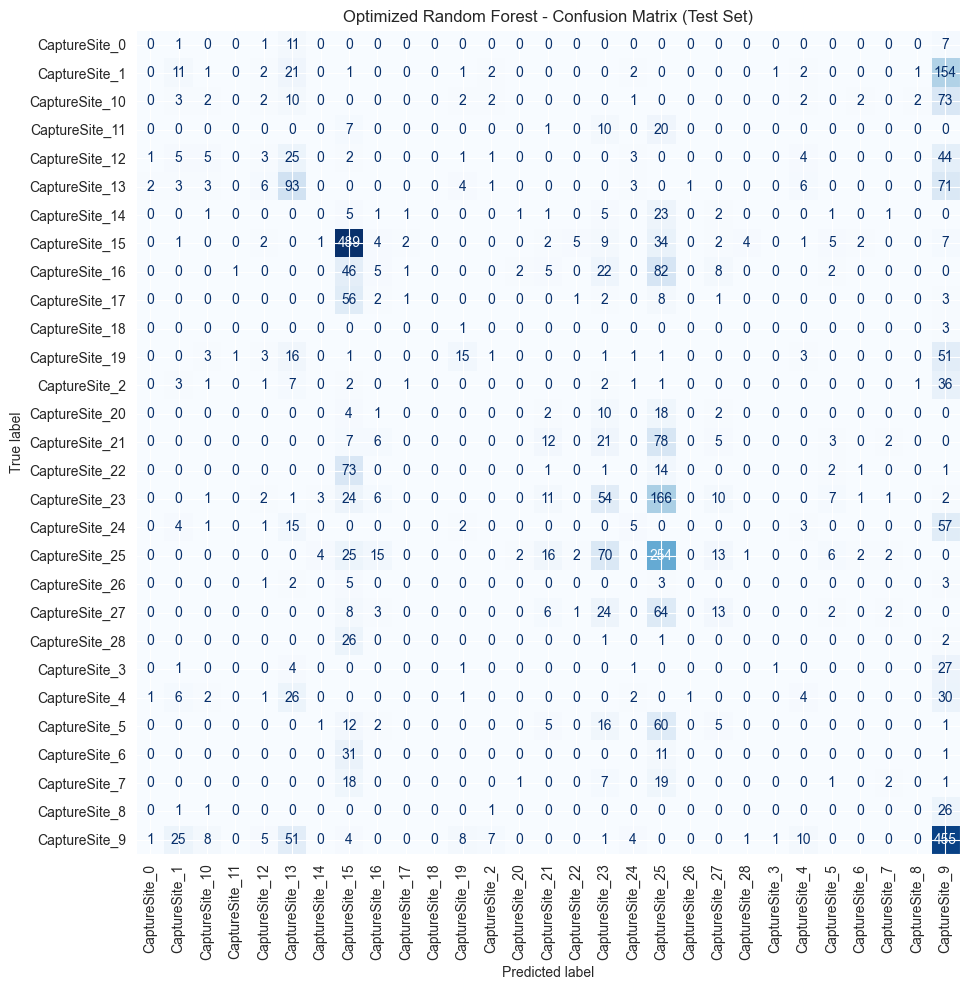

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=rf_best_model.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

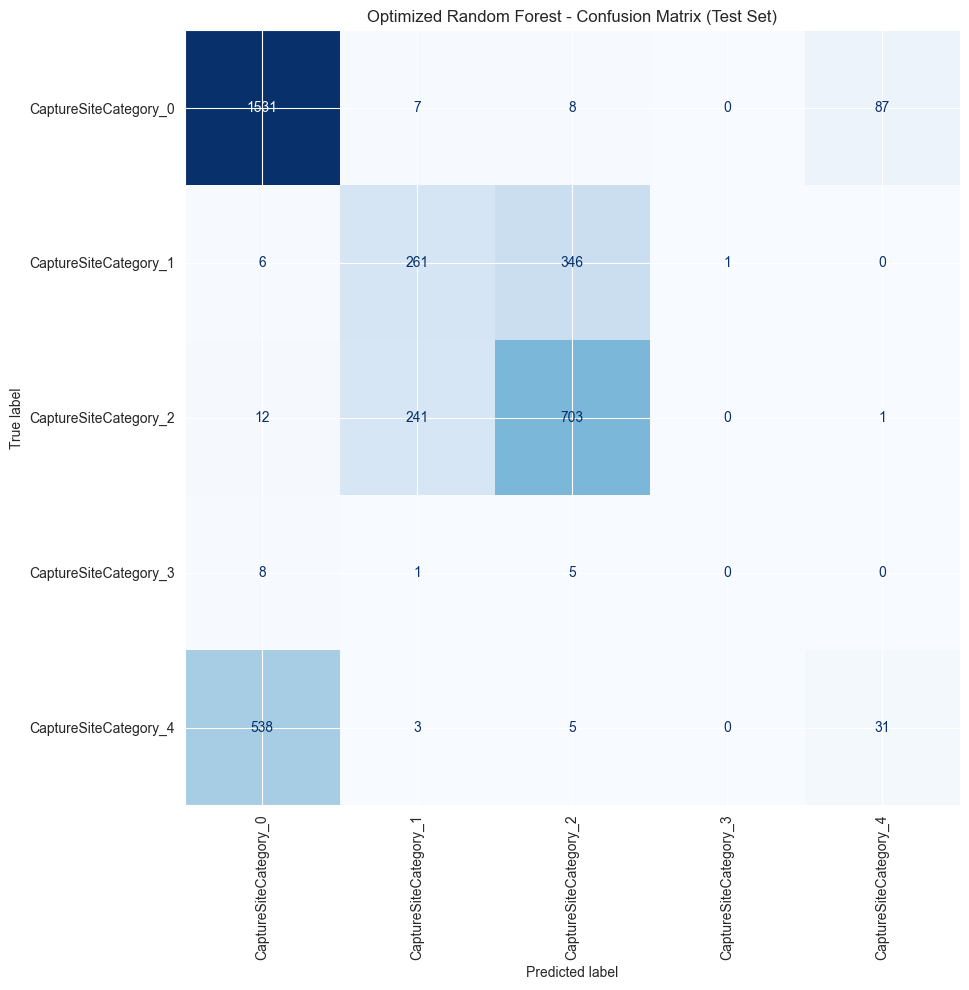

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm_alt, display_labels=rf_best_model_alt.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

### Best hyperparameters and cross-validated training score

In [26]:
rf_best_params, rf_best_score


({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 100},
 0.11073488592617624)

In [27]:
rf_best_params_alt, rf_best_score_alt

({'rf__criterion': 'gini',
  'rf__max_depth': 30,
  'rf__max_features': 'sqrt',
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 2,
  'rf__n_estimators': 100},
 0.4182577439767089)

### Feature importance of the optimized Random Forest

The following cells extract and display the feature importances of the best Random Forest model, including the one-hot encoded categorical features.

In [19]:
preprocess_best = rf_best_model.named_steps['preprocess']
rf_best = rf_best_model.named_steps['rf']

cat_encoder = preprocess_best.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
feature_names = np.concatenate([cat_feature_names, np.array(numeric_features)])

rf_feature_importances = rf_best.feature_importances_

rf_feature_importances_df = pd.DataFrame(
    {'feature': feature_names, 'importance': rf_feature_importances}
).sort_values('importance', ascending=False)

rf_feature_importances_df

,feature,importance
63,CCW_cm,0.182906
62,CCL_cm,0.182156
64,Weight_Kg,0.180971
0,ForagingGround_Creek,0.088078
1,ForagingGround_Ocean,0.063700
...,...,...
61,CalendarWeek_52,0.000716
8,Species_Species_7,0.000521
4,Species_Species_2,0.000126
3,Species_Species_1,0.000073


In [28]:
preprocess_best_alt = rf_best_model_alt.named_steps['preprocess']
rf_best_alt = rf_best_model_alt.named_steps['rf']

cat_encoder_alt = preprocess_best_alt.named_transformers_['cat']
cat_feature_names_alt = cat_encoder_alt.get_feature_names_out(categorical_features)
feature_names_alt = np.concatenate([cat_feature_names_alt, np.array(numeric_features)])

rf_feature_importances_alt = rf_best_alt.feature_importances_

rf_feature_importances_df_alt = pd.DataFrame(
    {'feature': feature_names_alt, 'importance': rf_feature_importances_alt}
).sort_values('importance', ascending=False)

rf_feature_importances_df_alt

,feature,importance
0,ForagingGround_Creek,0.273902
1,ForagingGround_Ocean,0.200670
64,Weight_Kg,0.116940
62,CCL_cm,0.116057
63,CCW_cm,0.115965
...,...,...
8,Species_Species_7,0.000318
61,CalendarWeek_52,0.000298
3,Species_Species_1,0.000023
4,Species_Species_2,0.000009


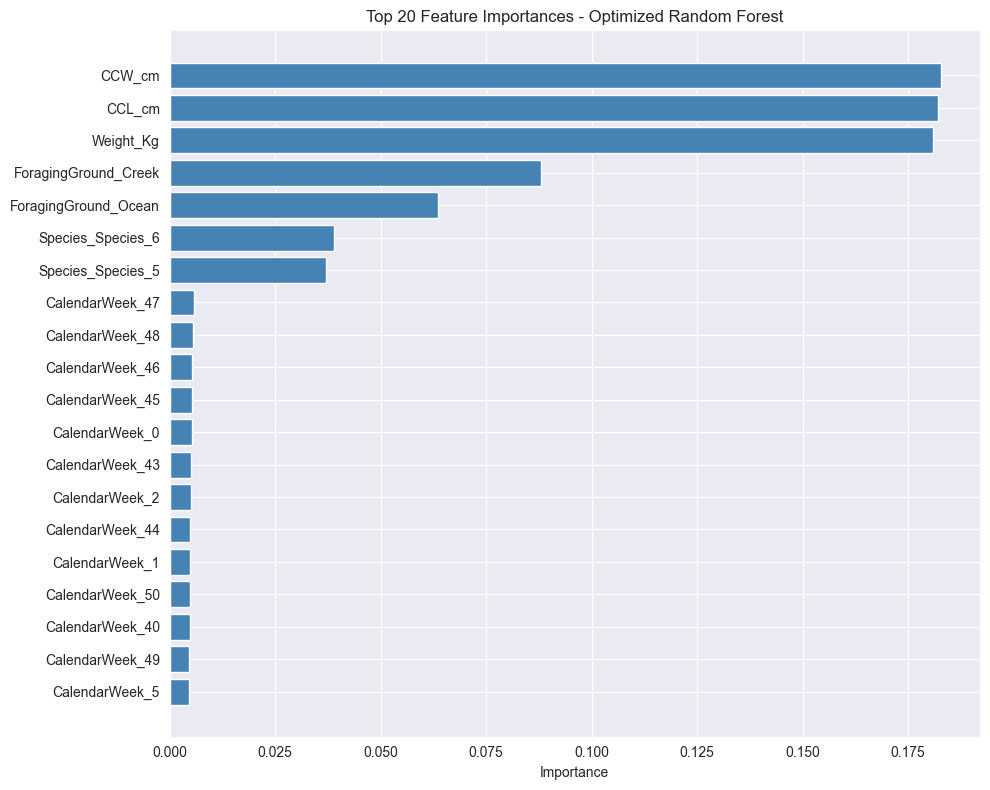

In [20]:
top_n = 20
top_features = rf_feature_importances_df.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()


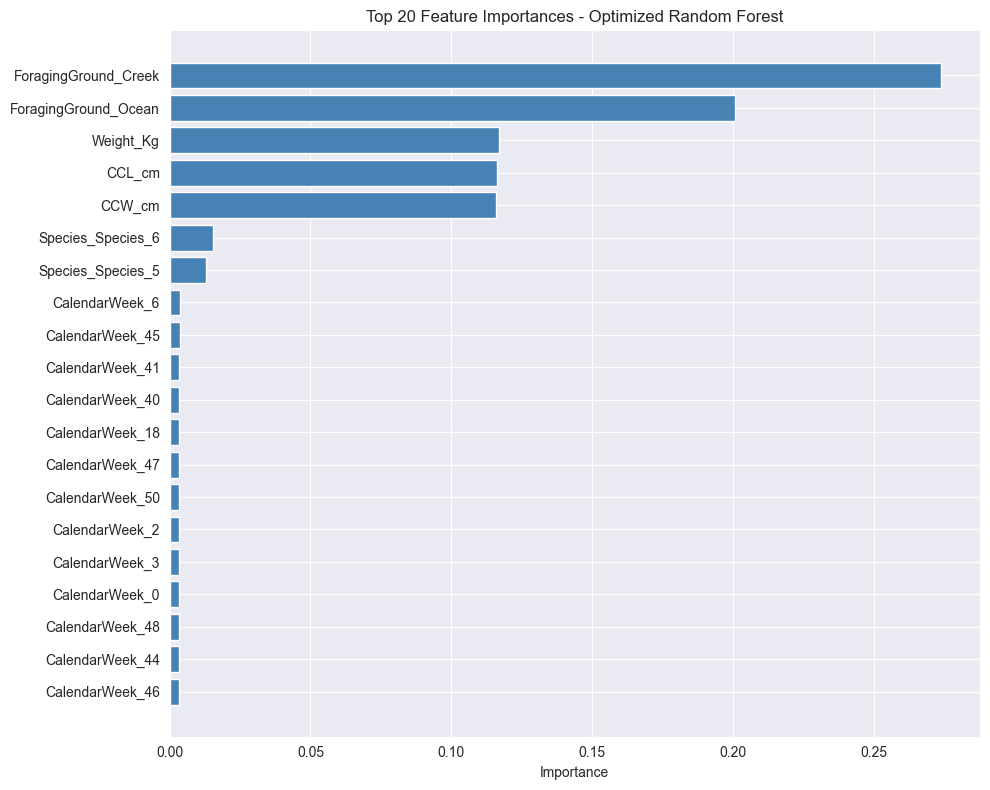

In [29]:
top_n = 20
top_features_alt = rf_feature_importances_df_alt.head(top_n).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(top_features_alt['feature'], top_features_alt['importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Feature Importances - Optimized Random Forest')
plt.tight_layout()
plt.show()